In [1]:
# Imports

# Talk about the category (majority missing values)

import os
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import utils

import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

pd.set_option("display.max_rows", 64)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 128)

LOCAL = "/home/main/InternetUseClassification/data"
KAGGLE = "/kaggle/input/child-mind-institute-problematic-internet-use"

In [2]:
df = pd.read_csv(f"{LOCAL}/train.csv")

split: utils.SplitData = utils.split(df)

preproc = utils.preprocess(split)

Splitting data
Dropped 1224 rows with missing `sii` data


Loading timeseries data:  10%|█         | 100/996 [00:05<00:46, 19.09it/s]


Generating timeseries summary data


Preprocessing folds:   0%|          | 0/5 [00:18<?, ?it/s]


UnboundLocalError: cannot access local variable 'test_X' where it is not associated with a value

**EDA**

In [3]:
# Read in provided train dataset
train_df = pd.read_csv(f"{LOCAL}/train.csv")
# High level overview of the dataset
print(f"There are {len(train_df.columns)} columns in the dataset.")
print(f"There are {len(train_df.id.unique())} unique ids in the dataset.")
train_df.describe()

There are 82 columns in the dataset.
There are 3960 unique ids in the dataset.


,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,743.000000,740.000000,740.000000,2322.000000,2282.000000,1074.000000,1062.000000,1074.000000,1063.000000,2310.000000,2271.000000,2305.000000,2267.000000,2307.000000,2269.000000,2324.000000,2285.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.00000,1991.000000,1991.000000,1991.000000,475.000000,1721.000000,2733.000000,2734.000000,2731.000000,2731.000000,2729.000000,2732.000000,2729.000000,2730.000000,2730.000000,2733.000000,2734.000000,2731.000000,2729.000000,2732.000000,2730.000000,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,4.989233,7.370270,27.581081,11.259690,0.476337,22.420438,1.829567,23.518622,1.904045,5.579654,0.330251,8.694924,0.618880,8.805635,0.620097,9.252775,0.785558,2.651431,6.719826,19.367048,1237.018187,2064.693747,20.825346,74.021708,15.030554,4.336495,16.855020,1.745354,33.173380,20.02299,67.301883,34.389466,53.998726,2.178853,2.589550,2.370655,2.177762,2.399854,0.839253,2.297545,1.063690,0.586295,1.246520,1.062637,1.304793,1.685443,0.244599,1.340051,1.035505,1.499634,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409
std,3.574648,0.483591,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,2.014072,3.189662,17.707751,11.807781,0.499549,10.833995,0.612585,11.148951,0.612344,7.390161,0.470407,3.429301,0.485769,3.422167,0.485469,2.988863,0.410525,1.028267,92.586325,5.047848,1872.383246,2836.246272,73.266287,199.433753,5.792505,6.356402,199.372119,0.680635,56.272346,70.21561,108.705918,84.050607,129.362539,0.849476,0.783937,1.673312,1.697117,1.588807,1.195601,1.705218,1.268282,1.049355,1.342582,1.258797,1.331715,1.543074,0.522956,1.411156,1.301712,1.492929,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122
min,5.000000,0.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-7.789610,0.048267,813.397000,1073.450000,1.789450,28.900400,7.864850,-194.163000,-8745.080000,1.000000,14.489000,4.63581,23.620100,4.655730,20.589200,0.660000,0.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000

In [4]:
# Understanding PCIAT-PCIAT_Total vs sii
for value in train_df.sii.unique():
    print(f"Unique value: {value}")
    print(train_df[train_df.sii == value]["PCIAT-PCIAT_Total"].describe())
    print("="*32)

# 0 -> 0 <= PCIAT-PCIAT_Total <= 30
# 1 -> 30 < PCIAT-PCIAT_Total < 50
# 2 -> 50 <= PCIAT-PCIAT_Total < 80
# 3 -> 80 <= PCIAT-PCIAT_Total

# Instead of making this a classification problem, we can make this a regression
# problem by predicting PCIAT-PCIAT_Total. This might make it more sensitive or
# accurate.

Unique value: 2.0
count    378.000000
mean      60.658730
std        7.787458
min       50.000000
25%       54.000000
50%       59.000000
75%       66.000000
max       79.000000
Name: PCIAT-PCIAT_Total, dtype: float64
Unique value: 0.0
count    1594.000000
mean       13.929737
std        10.331241
min         0.000000
25%         3.000000
50%        15.000000
75%        23.000000
max        30.000000
Name: PCIAT-PCIAT_Total, dtype: float64
Unique value: 1.0
count    730.000000
mean      38.726027
std        5.390029
min       31.000000
25%       34.000000
50%       38.000000
75%       43.000000
max       49.000000
Name: PCIAT-PCIAT_Total, dtype: float64
Unique value: nan
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: PCIAT-PCIAT_Total, dtype: float64
Unique value: 3.0
count    34.000000
mean     85.911765
std       4.230966
min      80.000000
25%      81.250000
50%      87.000000
75%      89.000000
max      93.000000
Name: 

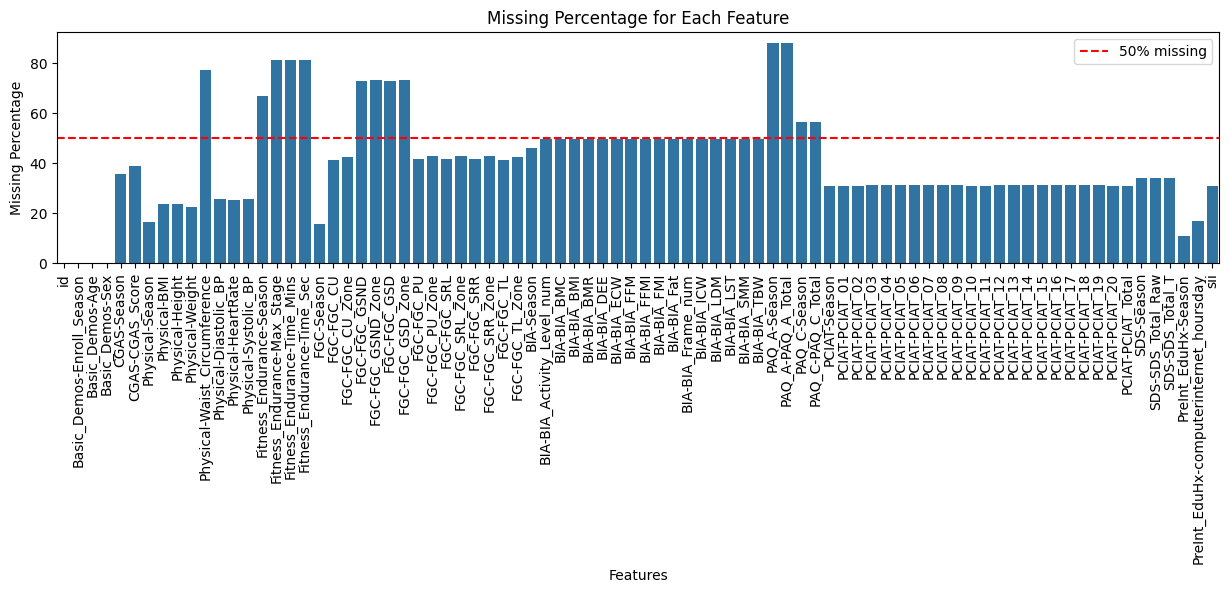

Original shape: (0, 82)
Shape after dropping missing `sii`: 2736


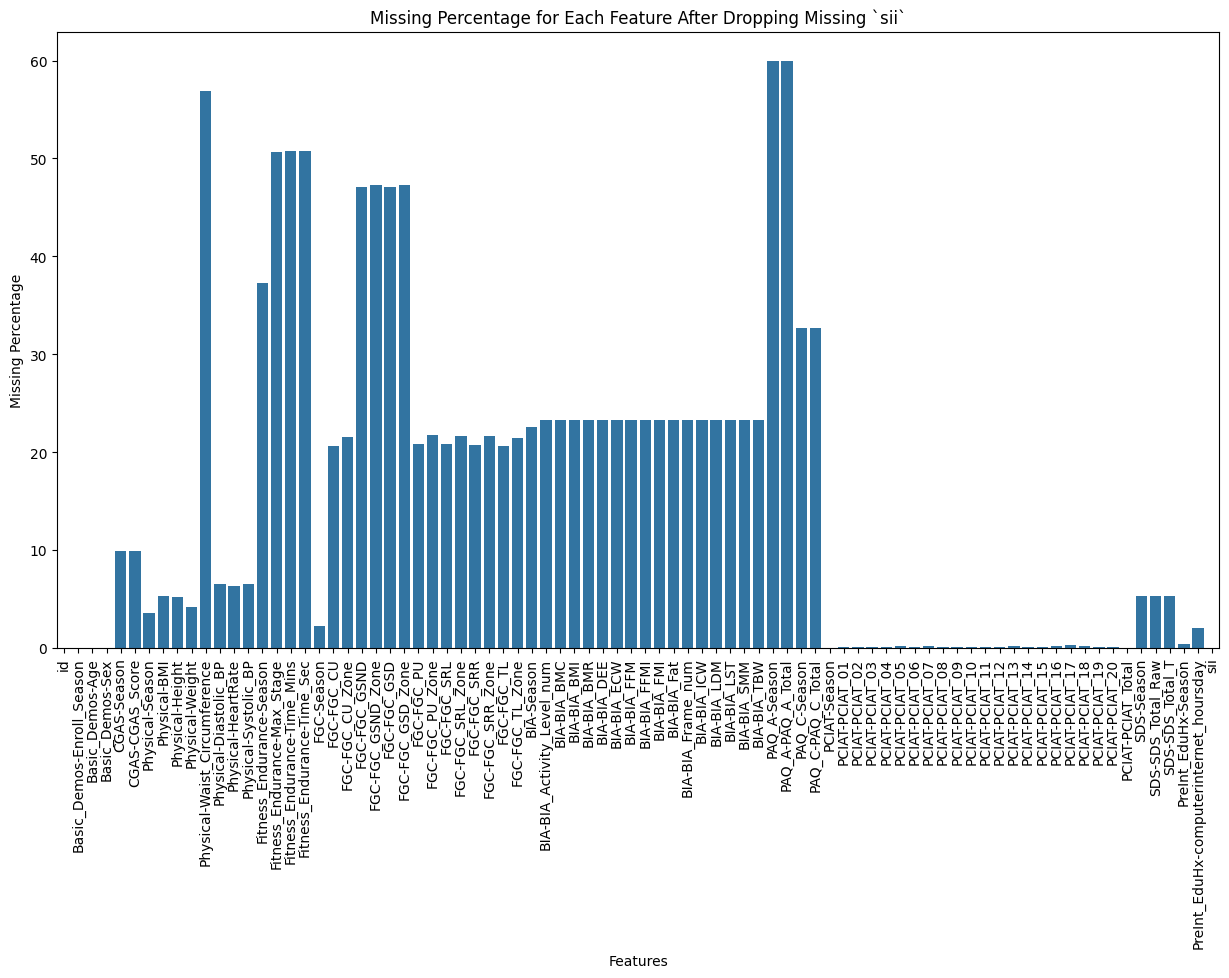

In [5]:
# Check for missing values
missing_pct = {}
for row in train_df.isnull().sum().items():
    missing_pct[row[0]] = round(row[1] / train_df.shape[0] * 100, 2)

plt.figure(figsize=(15, 3))
sns.barplot(x=list(missing_pct.keys()), y=list(missing_pct.values()))
plt.xlabel("Features")
plt.ylabel("Missing Percentage")
plt.title("Missing Percentage for Each Feature")
plt.xticks(rotation=90)
# add dotted bar at 50 and add to it to legend as 50% missing
plt.axhline(y=50, color="r", linestyle="--", label="50% missing")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Original shape: {train_df.dropna().shape}")

no_missing_sii = train_df.dropna(subset=["sii"])
print(f"Shape after dropping missing `sii`: {len(no_missing_sii)}")

missing_pct = {}
for row in no_missing_sii.isnull().sum().items():
    missing_pct[row[0]] = round(row[1] / train_df.shape[0] * 100, 2)
plt.figure(figsize=(15, 8))
sns.barplot(x=list(missing_pct.keys()), y=list(missing_pct.values()))
plt.xlabel("Features")
plt.ylabel("Missing Percentage")
plt.title("Missing Percentage for Each Feature After Dropping Missing `sii`")
plt.xticks(rotation=90)
plt.show()

  sii_formatted  count  percentage
1   Missing sii   1224   30.909091
0        sii: 0   1594   40.252525
2        sii: 1    730   18.434343
3        sii: 2    378    9.545455
4        sii: 3     34    0.858586


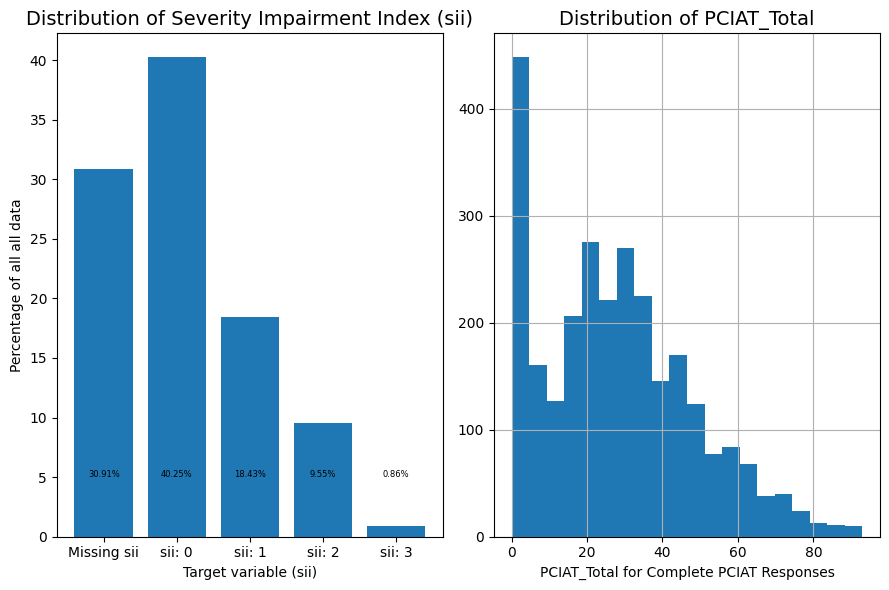

In [6]:
def format_sii(x):
    if x == 0.0:
        return "sii: 0"
    elif x == 1.0:
        return "sii: 1"
    elif x == 2.0:
        return "sii: 2"
    elif x == 3.0:
        return "sii: 3"
    else:
        return "Missing sii"

train_df["sii_formatted"] = train_df["sii"].apply(
    lambda x: format_sii(x)
)
sii_counts = train_df["sii_formatted"].value_counts().reset_index()
total = sii_counts["count"].sum()
sii_counts["percentage"] = (sii_counts["count"] / total) * 100

fig, axes = plt.subplots(1, 2, figsize=(9, 6))

# sii distribution, including missing values
sii_counts.sort_values("sii_formatted", inplace=True)
print(sii_counts)
axes[0].bar(sii_counts["sii_formatted"], sii_counts["percentage"])
axes[0].set_title("Distribution of Severity Impairment Index (sii)", fontsize=14)
for i, value in enumerate(sii_counts["sii_formatted"]):
    percentage = sii_counts.loc[sii_counts["sii_formatted"] == value, "percentage"].values[0]
    axes[0].text(i, 5, f"{round(percentage, 2)}%", ha="center", fontsize=6)
axes[0].set_xlabel("Target variable (sii)")
axes[0].set_ylabel("Percentage of all all data")

# PCIAT_Total for complete responses
axes[1].hist(train_df["PCIAT-PCIAT_Total"].dropna(), bins=20)
axes[1].set_title("Distribution of PCIAT_Total", fontsize=14)
axes[1].set_xlabel("PCIAT_Total for Complete PCIAT Responses")
axes[1].grid()

plt.tight_layout()
plt.show()


In [7]:
# Read in data descriptions
data_descriptions = pd.read_csv(f"{LOCAL}/data_dictionary.csv")

# Non-categorical columns
cont_columns = []
cat_columns = ["sii"]

verbose = False

# Plot pie charts/histograms (large output)
filled_train_df = train_df.fillna("nan")
for _, row in data_descriptions.iterrows():
    if verbose:
        print(f"Instrument: {row.Instrument}")
        print(f"Field: {row.Field}")
        print(f"Description: {row.Description}")
        print(row)

    if row.Type == "float" or row.Type == "int":
        cont_columns.append(row.Field)
        if verbose:   
            fig = plt.figure(figsize=(10, 8))
            plt.hist(train_df[row.Field], bins=40)
            plt.xlabel(row.Field)
            plt.ylabel("Frequency")
            plt.title(f"{row.Field} Histogram") 
            plt.show()

    if row.Type == "categorical int":
        cat_columns.append(row.Field)
        if verbose:
            value_counts = filled_train_df[row.Field].value_counts()
            fig, ax = plt.subplots()
            wedges, texts, autotexts = ax.pie(
                value_counts,
                labels=value_counts.index,
                autopct='%1.1f%%',
                startangle=90
            )
            plt.title(f"{row.Field} Pie Chart")  
            plt.show()

    if row.Type == "str" and row.Values is not np.nan:
        cat_columns.append(row.Field)
        if verbose:
            value_counts = filled_train_df[row.Field].value_counts()
            fig, ax = plt.subplots()
            wedges, texts, autotexts = ax.pie(
                value_counts,
                labels=value_counts.index,
                autopct='%1.1f%%',
                startangle=90
            )
            plt.title(f"{row.Field} Pie Chart")
            plt.show()

    if verbose: print("="*32)

print(f"Continuous columns: {cont_columns}")
print(f"Categorical columns: {cat_columns}")

Continuous columns: ['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'PCIAT-PCIAT_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']
Categorical columns: ['sii', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Sex', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FG

In [8]:
# Noted outliers in "CGAS-CGAS_Score" and some other numerical columns
print("CGAS-CGAS_Score percentiles:\n", train_df["CGAS-CGAS_Score"].quantile([0.25, 0.5, 0.75]))
values = train_df["CGAS-CGAS_Score"].to_list()
values.sort(reverse=True)
print(f"Top 5 largest values: {values[:5]}")

# We don't know if the 999.0 should be 99.0 so lets just drop that one row
train_df = train_df[train_df["CGAS-CGAS_Score"] <= 100.0]

# Re-running the cell above confirms that there was only one outlier row

CGAS-CGAS_Score percentiles:
 0.25    59.0
0.50    65.0
0.75    75.0
Name: CGAS-CGAS_Score, dtype: float64
Top 5 largest values: [nan, 78.0, 75.0, 71.0, 71.0]


['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'PCIAT-PCIAT_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']
PCA variance ratios: 
  Component 1 accounts 29.724% of the variance
  Component 2 accounts 12.647% of the variance
  Component 3 accounts 6.988% of the variance
  Component 4 accounts 5.8125% of the variance
  Component 5 accounts 5.1177% of the variance
  Component 6 accounts 4.7637% of the v

/tmp/ipykernel_78493/4171139254.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Explained Variance', y='Principal Component', data=pca_variance_df, palette='viridis')


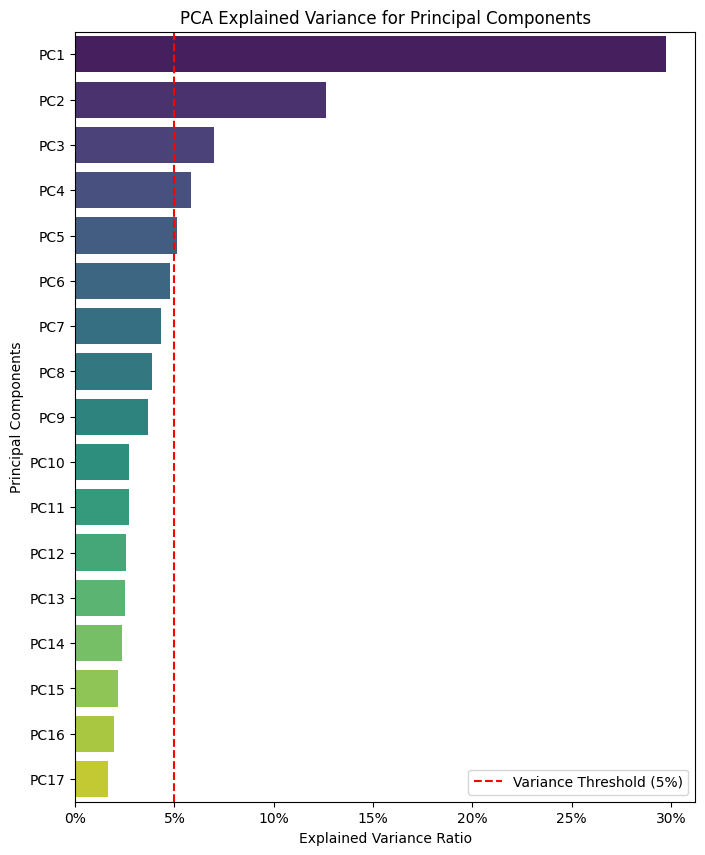

In [9]:
# PCA on continuous columns
cont_train_df = train_df[cont_columns]
print(cont_columns)
# Mean imputation for missing values
cont_columns_filled = cont_train_df.fillna(cont_train_df.mean())
if "PCIAT-PCIAT_Total" in cont_columns: cont_columns.remove("PCIAT-PCIAT_Total")
X = cont_columns_filled[cont_columns]
y = train_df["PCIAT-PCIAT_Total"]

sc = StandardScaler()
X = sc.fit_transform(X)

# PCA components that explain >=95% of the variance
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X)
print("PCA variance ratios: ")
for i, x in enumerate(pca.explained_variance_ratio_):
    print(
        f"  Component {i + 1} accounts {round(x * 100, 4)}% of the variance"
    )

# Plot PCA explained variance as a bar chart
pca_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance': pca.explained_variance_ratio_
})

# Set up the plot
plt.figure(figsize=(8, 10))
sns.barplot(x='Explained Variance', y='Principal Component', data=pca_variance_df, palette='viridis')
plt.axvline(x=0.05, color='red', linestyle='--', label='Variance Threshold (5%)')  # Reference line for 5%
plt.title('PCA Explained Variance for Principal Components')
plt.xlabel('Explained Variance Ratio')
plt.ylabel('Principal Components')
plt.gca().set_xticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_xticks()])
plt.legend()
plt.show()

/tmp/ipykernel_78493/19642546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_train_df["PCIAT-PCIAT_Total"] = y


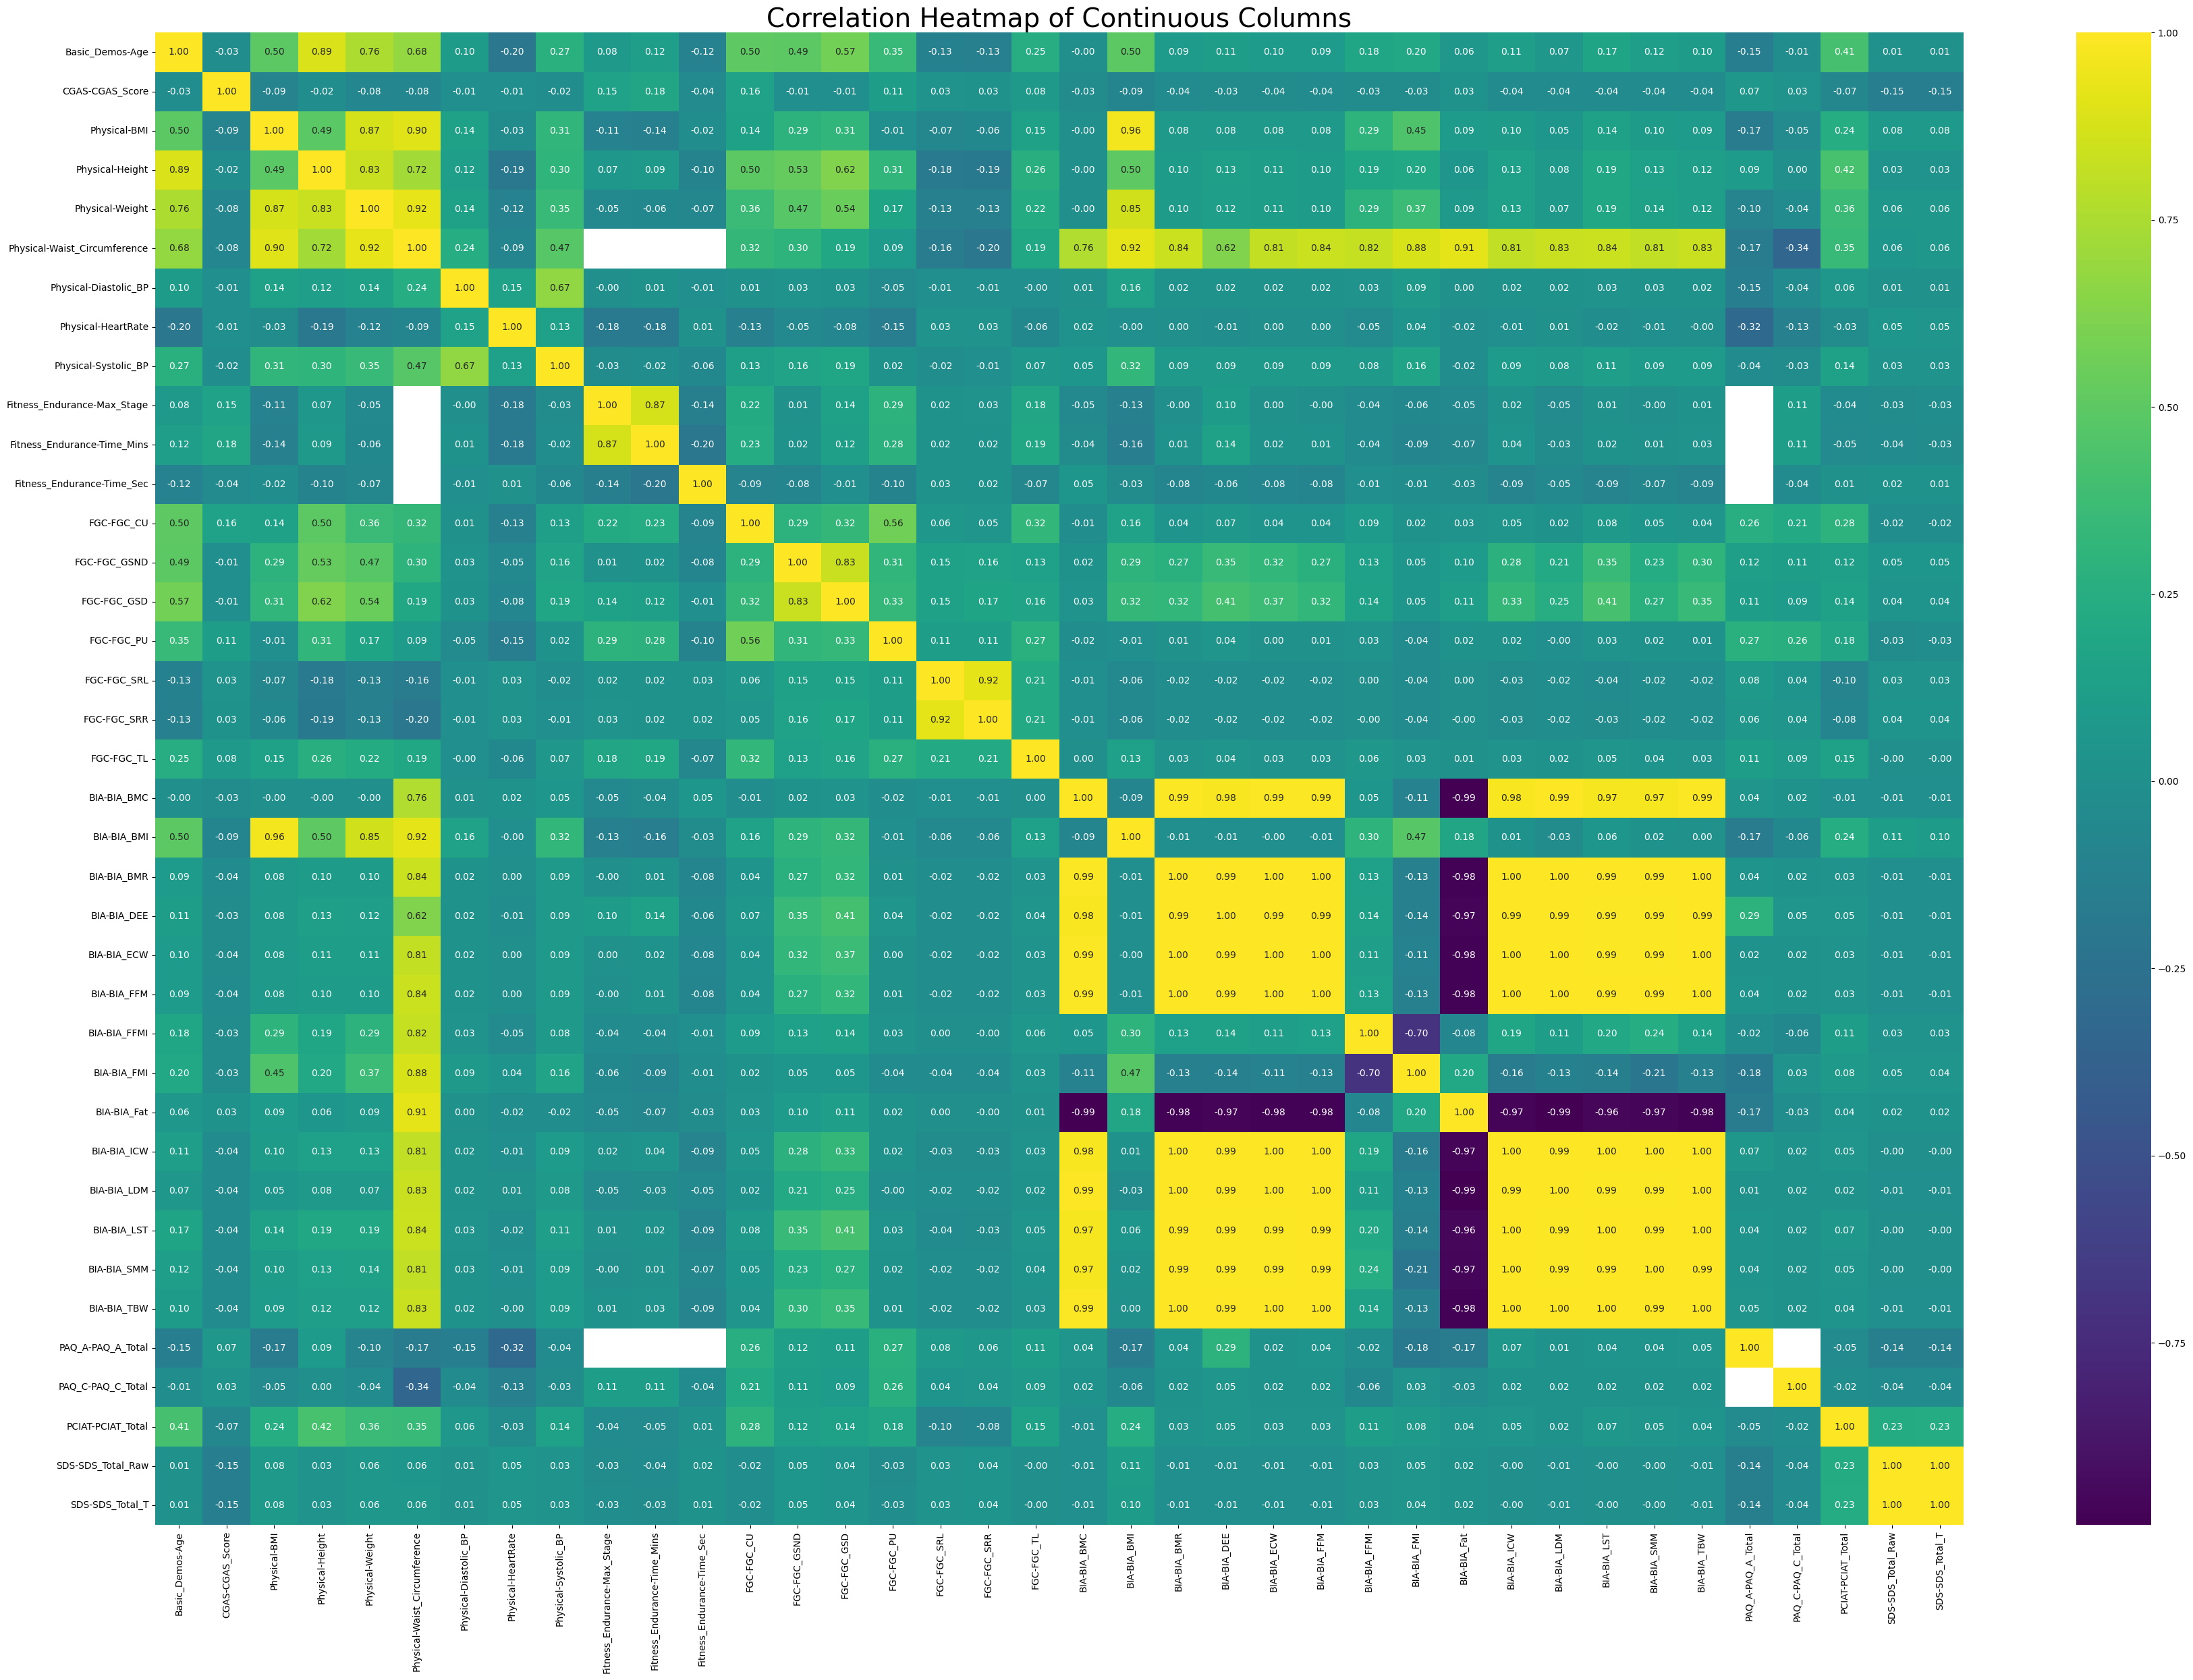

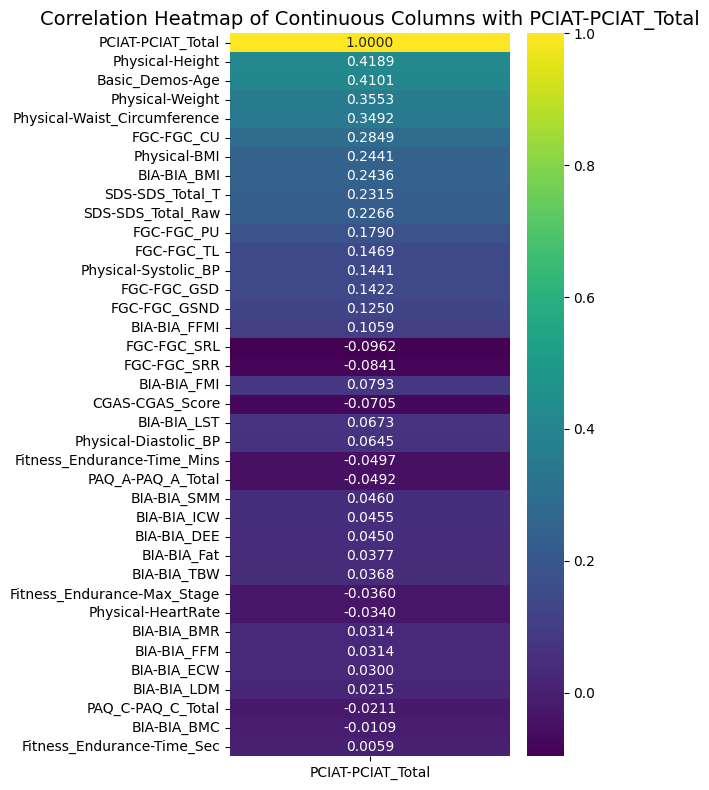

In [10]:
cont_train_df["PCIAT-PCIAT_Total"] = y
correlation_matrix = cont_train_df.corr()
plt.figure(figsize=(36, 25))
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlation Heatmap of Continuous Columns", fontsize=28)
plt.tight_layout()
plt.show()

# plot just the PCIAT-PCIAT_Total column using the same color scale
# Order the columns by correlation with PCIAT-PCIAT_Total using absolute value
correlation_matrix["PCIAT-PCIAT_Total"].sort_values(key=lambda x: abs(x), ascending=False)
plt.figure(figsize=(6, 8))
sns.heatmap(
    correlation_matrix["PCIAT-PCIAT_Total"].sort_values(key=lambda x: abs(x), ascending=False).to_frame(),
    annot=True,
    cmap="viridis",
    fmt=".4f"
)
plt.title("Correlation Heatmap of Continuous Columns with PCIAT-PCIAT_Total", fontsize=14)
plt.tight_layout()
plt.show()



Column: Basic_Demos-Enroll_Season
                      Source  ddof1       ddof2         F     p-unc       np2
0  Basic_Demos-Enroll_Season      3  1271.71908  2.487914  0.058993  0.002986
Reject null hypothesis

Column: Basic_Demos-Sex
            Source  ddof1        ddof2          F     p-unc       np2
0  Basic_Demos-Sex      1  1860.003257  23.003635  0.000002  0.009269
Reject null hypothesis

Column: CGAS-Season
        Source  ddof1        ddof2         F     p-unc       np2
0  CGAS-Season      3  1283.908405  0.467564  0.704955  0.000598

Column: Physical-Season
            Source  ddof1        ddof2         F     p-unc       np2
0  Physical-Season      3  1207.378454  2.111131  0.097061  0.002934
Reject null hypothesis

Column: Fitness_Endurance-Season
                     Source  ddof1       ddof2         F     p-unc       np2
0  Fitness_Endurance-Season      3  630.235398  2.004408  0.112124  0.041608

Column: FGC-Season
       Source  ddof1        ddof2         F    p-unc 

/tmp/ipykernel_78493/2138589845.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="p-value", y="Category", data=p_values_df, palette="viridis")


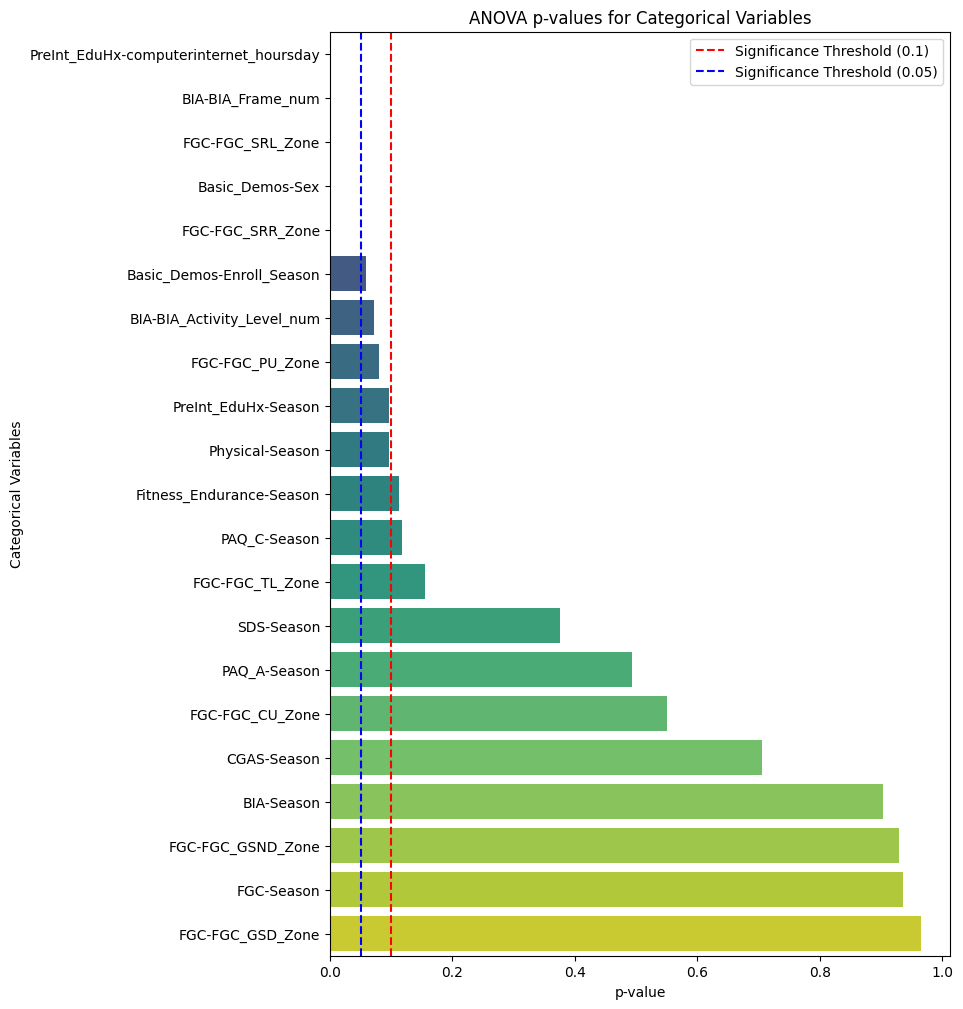

In [11]:
cat_to_use = []
# Cast a slightly wider net with a critical value of 10% for categorical columns
hypothesis_threshold = 0.1
p_values = []

for col in cat_columns:
    # Skip PCIAT columns since those are not available in the test dataset
    if "PCIAT" in col or "sii" in col: continue
    print(f"\nColumn: {col}")
    
    # Perform ANOVA
    aov = pg.welch_anova(dv="PCIAT-PCIAT_Total", between=col, data=train_df)
    print(aov)
    
    p_val = aov["p-unc"].values[0]
    p_values.append((col, p_val))
    
    if hypothesis_threshold >= p_val:
        print("\033[91mReject null hypothesis\033[0m")
        cat_to_use.append(col)
    else:
        # print("\033[92mFail to reject null hypothesis\033[0m")
        continue
    
    print("=" * 32)

# Create a DataFrame for p-values
p_values_df = pd.DataFrame(p_values, columns=["Category", "p-value"])

# Sort the DataFrame by p-value
p_values_df = p_values_df.sort_values(by="p-value")

# Set up the plot
plt.figure(figsize=(8, 12))
sns.barplot(x="p-value", y="Category", data=p_values_df, palette="viridis")
plt.axvline(x=hypothesis_threshold, color='red',
            linestyle='--', label='Significance Threshold (0.1)')
plt.axvline(x=0.05, color='blue',
            linestyle='--', label='Significance Threshold (0.05)')
plt.title('ANOVA p-values for Categorical Variables')
plt.xlabel('p-value')
plt.ylabel('Categorical Variables')
plt.legend()
plt.show()


In [ ]:
# Parquet timeseries EDA
train_df = pd.read_csv(f"{LOCAL}/train.csv")

target_dict = {}
for _, row in train_df.iterrows():
    target_dict[row["id"]] = row["PCIAT-PCIAT_Total"]

# for file_name in tqdm(os.listdir(f"{LOCAL}/series_train.parquet")):
#     if file_name.startswith("id="):
#         file_id = file_name.split("=")[1]
#         if file_id not in target_dict:
#             print(f"File {file_id} not in target_dict")

def read_timeseries(file_name, dir_name):
    df = pd.read_parquet(
        os.path.join(dir_name, file_name, "part-0.parquet"),
        "fastparquet",
    )
    # Convert nanosecond input to time of day in hours (24)
    df["daytime"] = df["time_of_day"].apply(lambda x: x / 3_600_000_000_000)
    df["id"] = file_name.split("=")[1]
    df["PCIAT-PCIAT_Total"] = target_dict.get(df["id"].values[0], np.nan)
    return df.drop("step", axis=1)

results = []
for file_name in tqdm(os.listdir(f"{LOCAL}/series_train.parquet")):
    if file_name.startswith("id="):
        results.append(read_timeseries(file_name, f"{LOCAL}/series_train.parquet"))
    # if len(results) > 50:
    #     break

timeseries_df = pd.concat(results)
timeseries_df = timeseries_df[["id", "PCIAT-PCIAT_Total", "daytime", "weekday", "light", "anglez", "enmo", "non-wear_flag"]]
print(timeseries_df.head())

# Plot bar chart of light, anglez, and enmo
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

# Light
ax[0].hist(timeseries_df["light"], bins=40, color="skyblue")
ax[0].set_title("Light Histogram")
ax[0].set_xlabel("Light")
ax[0].set_ylabel("Frequency")

# Anglez
ax[1].hist(timeseries_df["anglez"], bins=40, color="salmon")
ax[1].set_title("Anglez Histogram")
ax[1].set_xlabel("Anglez")
ax[1].set_ylabel("Frequency")

# Enmo
ax[2].hist(timeseries_df["enmo"], bins=40, color="lightgreen")
ax[2].set_title("Enmo Histogram")
ax[2].set_xlabel("Enmo")
ax[2].set_ylabel("Frequency")

plt.tight_layout()
plt.legend()
plt.show()

# print min, max, and means for each column
print(timeseries_df[["light", "enmo"]].describe())



 11%|█         | 110/996 [00:06<00:50, 17.62it/s]

In [22]:
def gen_timeseries_summary_data(df):
    summary_data = []

    for id, group in tqdm(df.groupby("id")):
        summary_data.append({
            "id": id,
            "light_median": group["light"].median(),
            "light_std": group["light"].std(),
            "light_min": group["light"].min(),
            "light_max": group["light"].max(),
            "light_25": group["light"].quantile(0.25),
            "light_50": group["light"].quantile(0.50),
            "light_75": group["light"].quantile(0.75),
            "light_90": group["light"].quantile(0.90),
            "anglez_median": group["anglez"].median(),
            "anglez_std": group["anglez"].std(),
            "anglez_min": group["anglez"].min(),
            "anglez_max": group["anglez"].max(),
            "anglez_25": group["anglez"].quantile(0.25),
            "anglez_50": group["anglez"].quantile(0.50),
            "anglez_75": group["anglez"].quantile(0.75),
            "anglez_90": group["anglez"].quantile(0.90),
            "enmo_median": group["enmo"].median(),
            "enmo_std": group["enmo"].std(),
            "enmo_min": group["enmo"].min(),
            "enmo_max": group["enmo"].max(),
            "enmo_25": group["enmo"].quantile(0.25),
            "enmo_50": group["enmo"].quantile(0.50),
            "enmo_75": group["enmo"].quantile(0.75),
            "enmo_90": group["enmo"].quantile(0.90),
            "PCIAT-PCIAT_Total": group["PCIAT-PCIAT_Total"].values[0]
        })

    return pd.DataFrame(summary_data).reset_index(drop=True)

def visualize_summary_data(df, label):
    summary_data = gen_timeseries_summary_data(df).drop("id", axis=1)
    correlation_matrix = summary_data.corr()
    plt.figure(figsize=(24, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f")
    plt.title("Correlation Heatmap of Timeseries Summary Data", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot just PCIAT-PCIAT_Total column
    correlation_matrix["PCIAT-PCIAT_Total"].sort_values(key=lambda x: abs(x), ascending=False)
    plt.figure(figsize=(6, 10))
    sns.heatmap(
        correlation_matrix["PCIAT-PCIAT_Total"].sort_values(key=lambda x: abs(x), ascending=False).to_frame(),
        annot=True,
        cmap="viridis",
        fmt=".4f"
    )
    plt.title(f"Correlation Heatmap of Timeseries Summary Data with PCIAT-PCIAT_Total for: {label}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # print list of non-matching column pairs with absolute correlations > 0.7
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            correlation = correlation_matrix.loc[col1, col2]
            if abs(correlation) > 0.7:
                print(f"Columns {col1} and {col2} have a correlation of {correlation}")

    # PCA components that explain >=95% of the variance
    X = summary_data.drop("PCIAT-PCIAT_Total", axis=1)
    y = summary_data["PCIAT-PCIAT_Total"]
    sc = StandardScaler()
    

    del summary_data

In [ ]:
# Visualize correlations for timeseries data summary statistics vs PCIAT-PCIAT_Total
# visualize_summary_data(timeseries_df)
# visualize_summary_data(timeseries_df[timeseries_df["non-wear_flag"] == 0.0])
# We should definately exlude times where the watch is not being worn
# this makes intuitive sense and we see that excluding non-wear times improves correlations

timeseries_df = timeseries_df[timeseries_df["non-wear_flag"] == 0.0]
visualize_summary_data(timeseries_df[timeseries_df["weekday"].isin([0, 1, 2, 3, 4])], "weekday")
visualize_summary_data(timeseries_df[timeseries_df["weekday"].isin([5, 6])], "weekend")

# Order of most important features is different pretty different for weekdays vs weekends
# So it makes sense to split and include summary stats for both in the final features